In [41]:
from sklearn.datasets import make_blobs 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import binary_dilation, distance_transform_edt #for connecting voxels

from skimage.draw import line

In [9]:
X, y = make_blobs(n_samples=10, centers=None, n_features=3, random_state=0)

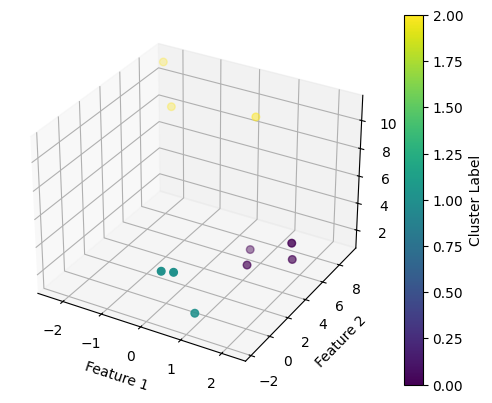

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', s=30)

# Adding axis labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.colorbar(scatter, ax=ax, label="Cluster Label")
plt.show()

In [77]:
def create_voxel_grid(points, grid_size=30):
    voxels = np.zeros((grid_size, grid_size, grid_size), dtype=float)
    scaled_points = np.floor((points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0)) * (grid_size - 1)).astype(int)
    for idx, point in enumerate(scaled_points):
        voxels[point[0], point[1], point[2]] = idx + 1  # Example value: index-based, or set to 1 or another constant

    # Connect consecutive points with values along the path
    for i in range(len(scaled_points) - 1):
        start, end = scaled_points[i], scaled_points[i + 1]
        num_steps = np.max(np.abs(end - start))
        for t in range(num_steps + 1):
            intermediate_point = start + (end - start) * t // num_steps
            # Assign a value, e.g., interpolation index-based or distance from the starting point
            voxels[intermediate_point[0], intermediate_point[1], intermediate_point[2]] = i + (t / (num_steps + 1))

    return voxels

In [89]:
#our base blob
X_base, Y = make_blobs(n_samples=15, centers=1, n_features=3, cluster_std=0.5, random_state=42)
voxel_base = create_voxel_grid(X_base)

#1 identical blob - same as base blob
voxel_identical = create_voxel_grid(X_base)

#2 similiar blob - with small noice
X_similar = X_base + np.random.normal(0, 0.2, X_base.shape)
voxel_similar = create_voxel_grid(X_similar)

#3 different blob - different center
X_different, _ = make_blobs(n_samples=15, centers=[[10, 10, 10]], n_features=3, cluster_std=0.5, random_state=42)
voxel_different = create_voxel_grid(X_different)

#4 blob with growth (narośl) - with new ponts
X_growth = np.vstack([X_base, X_base + [1, 1, 1]])
voxel_growth = create_voxel_grid(X_growth)

#5 blob with missing part - with removed points
X_missing = X_base[X_base[:, 0] < X_base[:, 0].mean()]  # Remove half the points based on x-coordinate
voxel_missing = create_voxel_grid(X_missing)


In [86]:
non_zero_one_count = np.count_nonzero((voxel_base != 0) & (voxel_base != 1))
print(f"Number of values in voxel_base that are neither 0 nor 1: {non_zero_one_count}")


Number of values in voxel_base that are neither 0 nor 1: 925


In [87]:
non_zero_count = np.count_nonzero((voxel_base != 0))
print(f"Number of values in voxel_base that are not 0: {non_zero_count}")


Number of values in voxel_base that are not 0: 926


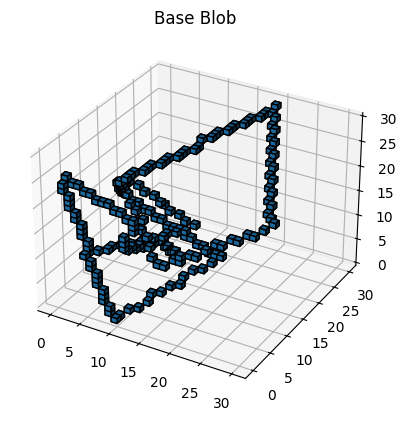

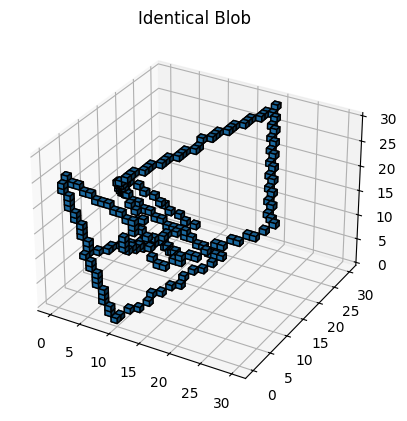

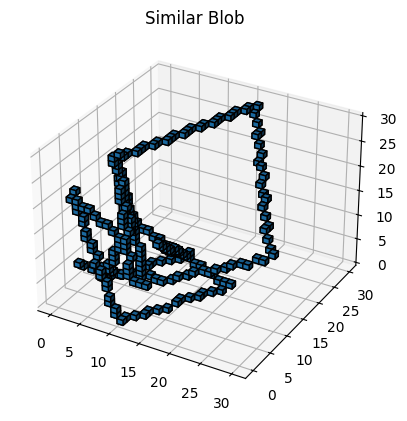

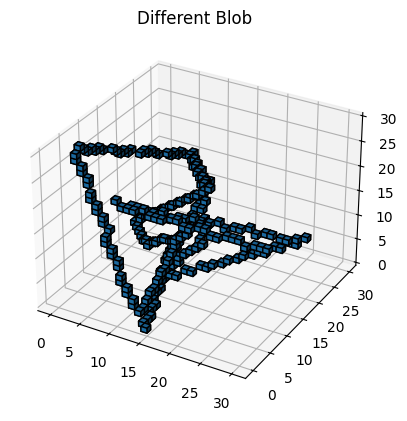

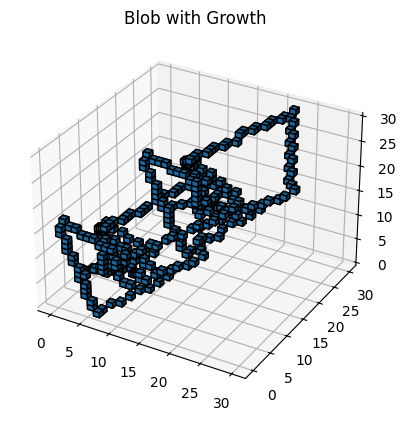

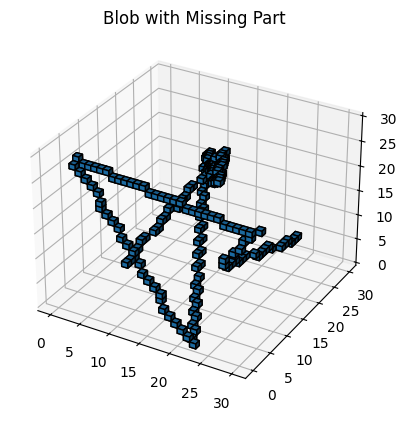

In [90]:
voxels = [voxel_base, voxel_identical, voxel_similar, voxel_different, voxel_growth, voxel_missing]
titles = ["Base Blob", "Identical Blob", "Similar Blob", "Different Blob", "Blob with Growth", "Blob with Missing Part"]

for i, voxel in enumerate(voxels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.voxels(voxel, edgecolor="k")
    ax.set_title(titles[i])
    plt.show()

In [93]:
def plot_voxel(voxel_data, title="Voxel Grid"):
    # Get the indices of the active voxels
    x, y, z = voxel_data.nonzero()

    # Calculate distances from the center of the voxel grid
    center = np.array(voxel_data.shape) / 2
    distances = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    
    # Normalize distances for coloring (0 to 1 range)
    max_distance = np.max(distances)
    normalized_distances = distances / max_distance if max_distance > 0 else distances

    colors = normalized_distances  

    # Create the 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(size=3, symbol= 'square', color=colors, colorscale='Viridis', showscale=True)  # You can change colorscale
    )])
    
    # Update layout
    fig.update_layout(title=title, scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ))
    
    fig.show()

In [94]:
plot_voxel(voxel_base, title="Basic Voxel Grid")
plot_voxel(voxel_identical, title="Identical Voxel Grid")
plot_voxel(voxel_similar, title="Similar Voxel Grid- with small noise")
plot_voxel(voxel_different, title="Different Voxel Grid- different center")
plot_voxel(voxel_growth, title="Growth Voxel Grid- with new points")
plot_voxel(voxel_missing, title="Missing Voxel Grid- with removed points")

In [95]:
#now to not further more se this notebook, we save the blobs to files
names = ["base", "identical", "similiar", "different", "growth", "missing"]
for name, voxel in zip(names, voxels):
    filename = f"voxel_grid_{name}.npy"
    np.save(filename, voxel)

### How to load the voxels
just copy and paste the given code here:

In [26]:
voxel_base = np.load("voxel_grid_base.npy")
voxel_identical = np.load("voxel_grid_identical.npy")
voxel_similar = np.load("voxel_grid_similiar.npy")
voxel_different = np.load("voxel_grid_different.npy")
voxel_growth = np.load("voxel_grid_growth.npy")
voxel_missing = np.load("voxel_grid_missing.npy")


In [27]:
"""
and if you want to visualize the voxels, just use:

import numpy as np
import plotly.graph_objects as go

def plot_voxel(voxel_data, title="Voxel Grid"):
    # Get the indices of the active voxels
    x, y, z = voxel_data.nonzero()

    # Calculate distances from the center of the voxel grid
    center = np.array(voxel_data.shape) / 2
    distances = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)
    
    # Normalize distances for coloring (0 to 1 range)
    max_distance = np.max(distances)
    normalized_distances = distances / max_distance if max_distance > 0 else distances

    colors = normalized_distances  

    # Create the 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(size=3, symbol= 'square', color=colors, colorscale='Viridis', showscale=True)  # You can change colorscale
    )])
    
    # Update layout
    fig.update_layout(title=title, scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ))
    
    fig.show()



plot_voxel(voxel_base, title="Basic Voxel Grid")
plot_voxel(voxel_identical, title="Identical Voxel Grid")
plot_voxel(voxel_similar, title="Similar Voxel Grid- with small noise")
plot_voxel(voxel_different, title="Different Voxel Grid- different center")
plot_voxel(voxel_growth, title="Growth Voxel Grid- with new points")
plot_voxel(voxel_missing, title="Missing Voxel Grid- with removed points")

"""



'\nand if you want to visualize the voxels, just use:\n\nimport numpy as np\nimport plotly.graph_objects as go\n\ndef plot_voxel(voxel_data, title="Voxel Grid"):\n    # Get the indices of the active voxels\n    x, y, z = voxel_data.nonzero()\n\n    # Calculate distances from the center of the voxel grid\n    center = np.array(voxel_data.shape) / 2\n    distances = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)\n    \n    # Normalize distances for coloring (0 to 1 range)\n    max_distance = np.max(distances)\n    normalized_distances = distances / max_distance if max_distance > 0 else distances\n\n    colors = normalized_distances  \n\n    # Create the 3D scatter plot\n    fig = go.Figure(data=[go.Scatter3d(\n        x=x,\n        y=y,\n        z=z,\n        mode=\'markers\',\n        marker=dict(size=3, symbol= \'square\', color=colors, colorscale=\'Viridis\', showscale=True)  # You can change colorscale\n    )])\n    \n    # Update layout\n    fig.update_layout(